In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from sklearn import metrics
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

Here we have semantic (or class) segmentation: we paint each front door as dark green, even if we have 5 or just 1 in the image (as opposed to instance segmentation, where we would assign a different color to each front door object/instance).

Useful links & resources:

- https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923
- https://www.tensorflow.org/tutorials/images/segmentation
- https://github.com/sheikhazhanmohammed/sadma
- https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
- https://github.com/milesial/Pytorch-UNet
- https://github.com/asanakoy/kaggle_carvana_segmentation/tree/master

Pretrained models:

- https://pytorch.org/serve/model_zoo.html
- https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

In [2]:
# Image names in all folders are of the form XXXX.png (ex: 0001.png)

IMAGES_FOLDER = './carseg_data/images/'
BLACK_CAR_FOLDER = 'black_5_doors/'
ORANGE_CAR_FOLDER = 'orange_3_doors/'
REAL_CAR_FOLDER = 'photo/'
SEGMENTATION_FOLDER = 'with_segmentation/'
NO_SEGMENTATION_FOLDER = 'no_segmentation/'

torch.Size([3, 360, 640]) tensor(255, dtype=torch.uint8)


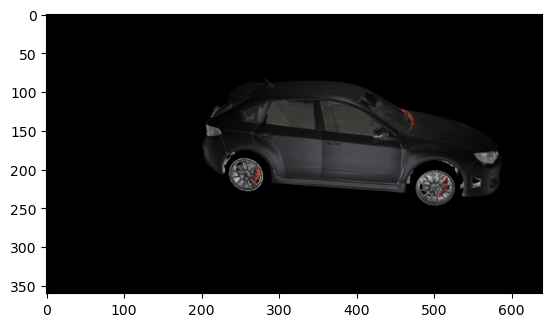

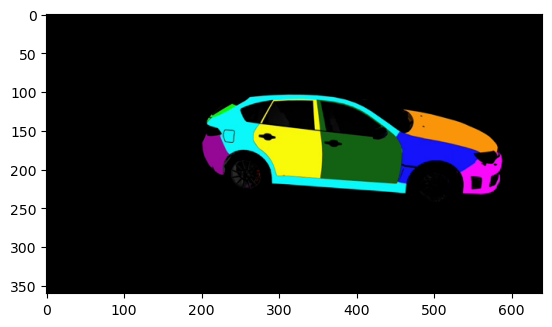

In [3]:
# Read images and see examples
IMAGE_PATH = '/0001.png'

image_original = torchvision.io.read_image(IMAGES_FOLDER + BLACK_CAR_FOLDER + NO_SEGMENTATION_FOLDER + IMAGE_PATH)
image_segmented = torchvision.io.read_image(IMAGES_FOLDER + BLACK_CAR_FOLDER + SEGMENTATION_FOLDER + IMAGE_PATH)

print(image_original.shape, image_original.max())

plt.imshow(image_original.permute(1, 2, 0))
plt.show()
plt.imshow(image_segmented.permute(1, 2, 0))
plt.show()

In [4]:
# The shapes of all 3 categories of images, different across folders but consisten inside itself
# Also the maximum in all images is 255, so scaling all images by dividing with 255 would be appropriate

# BLACK_DIR_ORIGINAL = IMAGES_FOLDER + BLACK_CAR_FOLDER + NO_SEGMENTATION_FOLDER
# ORANGE_DIR_ORIGINAL = IMAGES_FOLDER + ORANGE_CAR_FOLDER + NO_SEGMENTATION_FOLDER
# REAL_DIR_ORIGINAL = IMAGES_FOLDER + REAL_CAR_FOLDER + NO_SEGMENTATION_FOLDER

# images_max = torch.tensor(0)

# unique_shapes = set()
# for file in os.listdir(BLACK_DIR_ORIGINAL):
#     filename = os.fsdecode(file)
#     image = torchvision.io.read_image(BLACK_DIR_ORIGINAL + filename)
#     images_max = max(images_max, image.max())
#     unique_shapes.add(image.shape)
# print("Black unique shapes: " + str(unique_shapes))

# unique_shapes = set()
# for file in os.listdir(ORANGE_DIR_ORIGINAL):
#     filename = os.fsdecode(file)
#     image = torchvision.io.read_image(ORANGE_DIR_ORIGINAL + filename)
#     images_max = max(images_max, image.max())
#     unique_shapes.add(image.shape)
# print("Orange unique shapes: " + str(unique_shapes))

# unique_shapes = set()
# for file in os.listdir(REAL_DIR_ORIGINAL):
#     filename = os.fsdecode(file)
#     image = torchvision.io.read_image(REAL_DIR_ORIGINAL + filename)
#     images_max = max(images_max, image.max())
#     unique_shapes.add(image.shape)
# print("Real unique shapes: " + str(unique_shapes))

# print("Images max: " + str(images_max))

In [5]:
ARRAYS_FOLDER = './carseg_data/arrays/'
BLACK_ARRAY_PREFIX = 'black_5_doors_'
ORANGE_ARRAY_PREFIX = 'orange_3_doors_'
PHOTO_ARRAY_PREFIX = 'photo_'

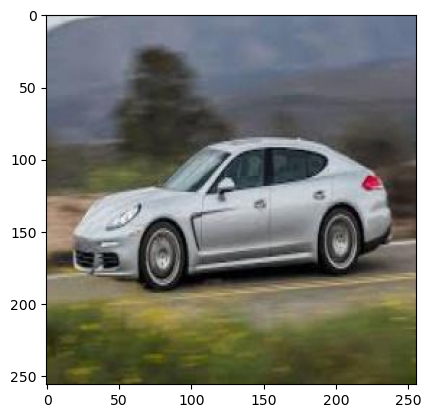

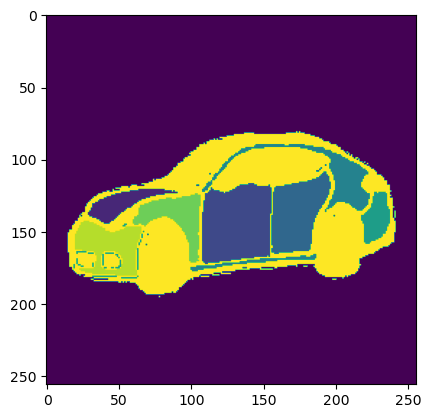

(256, 256, 4) 255
[0, 10, 20, 30, 40, 50, 70, 80, 90]


In [6]:
# Read and analyse and describe the .npy files
npy_file = np.load('./carseg_data/arrays/photo_0001.npy')

plt.imshow(npy_file[:,:,0:3])
plt.show()
plt.imshow(npy_file[:,:,3])
plt.show()
print(npy_file.shape, npy_file.max())

unique_color_labels = set()
[unique_color_labels.add(x) for x in npy_file[:,:,3].flatten()]

print(sorted(unique_color_labels)) # this corresponds to the 9 classes/segments described in the readme

In [7]:
# Check that all .npy files have the same shape and structure
unique_shapes = set()
for file in os.listdir(ARRAYS_FOLDER):
    filename = os.fsdecode(file)
    image = np.load(ARRAYS_FOLDER + filename)
    unique_shapes.add(image.shape)
    
print("Numpy files unique shapes: " + str(unique_shapes))

Numpy files unique shapes: {(256, 256, 4)}


In [8]:
#Add the numpy files
# Initialize dictionaries to store arrays for different categories
folder_path = ARRAYS_FOLDER
npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
black_5_doors_arrays = {}
orange_3_doors_arrays = {}
photo_arrays = {}

# Categorize the arrays based on the file names
for file in npy_files:
    file_path = os.path.join(folder_path, file)
    
    # Load the numpy array and normalize by dividing with the maximum value
    sample_tensor = torch.from_numpy(np.load(file_path)) / 255
    
    sample_tensor = sample_tensor.permute(2, 0, 1) # Reshaping from HxWxC to CxHxW
    
    # Extract the image data and target values
    image_data = sample_tensor[0:3,:,:]  # First 3 channels are the image data
    target = sample_tensor[3,:,:]  # Fourth channel contains target values
    
    if file.startswith('black_5_doors'):
        black_5_doors_arrays[file] = {'image_data': image_data, 'target': target}       
    elif file.startswith('orange_3_doors'):
        orange_3_doors_arrays[file] = {'image_data': image_data, 'target': target}
    elif file.startswith('photo_'):
        photo_arrays[file] = {'image_data': image_data, 'target': target}
        
image_data_list = []
target_list = []

# Loop through the list of dictionaries and extract image_data
for data_dict in black_5_doors_arrays:
    image_data = black_5_doors_arrays[data_dict]['image_data']
    target_data = black_5_doors_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)
for data_dict in orange_3_doors_arrays:
    image_data = orange_3_doors_arrays[data_dict]['image_data']
    target_data = orange_3_doors_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)
for data_dict in photo_arrays:
    image_data = photo_arrays[data_dict]['image_data']
    target_data = photo_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)

### TODO: maybe we want to split by color so that we get and equal distribution of all 3 categories
### TODO: do we want the test data to be only the first 30 images from photo? as written in the given README

In [9]:
images_tensor = torch.stack(image_data_list, dim=0)
masks_tensor = torch.stack(target_list, dim=0)
dataset = TensorDataset(images_tensor, masks_tensor)

DATASET_LENGTH = len(dataset)
train_size = math.floor(DATASET_LENGTH * 0.8)
val_size = math.floor(DATASET_LENGTH * 0.1)
test_size = DATASET_LENGTH - train_size - val_size

generator_seed = torch.Generator().manual_seed(0)
train_set, temp_set = random_split(dataset, [train_size, val_size + test_size], generator=generator_seed)
val_set, test_set = random_split(temp_set, [val_size, test_size], generator=generator_seed)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
train_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [13]:
# Test just to see that things still work
# x, y = next(iter(train_loader))

# sample_index = 30
# img = x[sample_index]
# mask = y[sample_index]

# plt.imshow(img.permute(1, 2, 0))
# plt.show()
# plt.imshow(mask)
# plt.show()

In [14]:
# # Split the data into train-test-validation
# # I think that we only need the npy files
# X = np.array(image_data_list)
# y = np.array(target_list)

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # used during training to get the index range of the next batch
# get_slice = lambda i, size: range(i * size, (i + 1) * size) 

# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)

# print("X_val shape:", X_val.shape)
# print("y_val shape:", y_val.shape)

# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # output shape excluding channels (same for both height and width) is:
        # out = (in - 1) * stride - 2 * padding + (kernel_size - 1) + 1
        # here, with padding = 0, we get:
        # out = (stride * in) - (2 * stride) + kernel
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1) # x1 and x2 need to have the same number of rows, I think
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) # maybe wrap this in a sigmoid?

    def forward(self, x):
        return self.conv(x)

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.inc = (ConvBlock(3, 64, 64)) 
        self.down1 = (Down(64, 128)) 
#         self.down2 = (Down(128, 256)) 
#         self.down3 = (Down(256, 512)) 
#         self.down4 = (Down(512, 1024)) 
#         self.up1 = (Up(1024, 512)) 
#         self.up2 = (Up(512, 256))
#         self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, 1))

    def forward(self, x):
        x1 = self.inc(x) # x1 HxW: 256x256
        x2 = self.down1(x1) # x2 HxW: 128x128
        # x3 = self.down2(x2) # x3 HxW: 64x64
        # x4 = self.down3(x3) # x4 HxW: 32x32
        # x5 = self.down4(x4) # x5 HxW: 16x16
        # x = self.up1(x5, x4) # up(x5) gives 32x32, concat with x4, HxW remains 32x32 and the channels are added
        # x = self.up2(x, x3)
        # x = self.up3(x, x2)
        x = self.up4(x2, x1) # x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [12]:
def save_model(model, optimizer, epoch, loss, accuracy, save_path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }
    torch.save(state, save_path)
    print(f'Model saved at {save_path}')

def load_model(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    print(f'Model loaded from {load_path}')
    return model, optimizer, epoch, loss, accuracy

In [19]:
def train_model(model, epochs, batch_size, optimizer, loss_fn):
    if not torch.cuda.is_available():
        print("CUDA NOT AVAILABLE!!!!")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_steps = math.ceil(len(train_set) / batch_size)
    train_losses = []
    val_losses = []
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        step = 1
        model.train()
        
        for inputs, masks in train_loader:
            print(f"Epoch: {epoch}, step: {step} out of {train_steps}.")
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            
            batch_loss = loss_fn(output.squeeze(), masks)
            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item()
            step += 1
            
        train_losses.append(epoch_loss / batch_size)
        
        train_preds, train_targs = [], []
        with torch.no_grad():
            model.eval()
            val_loss = 0
            for inputs, masks in val_loader:
                output = model(inputs)
                val_loss += loss_fn(output.squeeze(), masks).item()
            
            val_losses.append(val_loss / batch_size)
            
        print(f"Epoch train loss: {train_losses[-1]}")
        print(f"Epoch validation loss: {val_losses[-1]}")

In [20]:
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss()
train_model(model, 1, 16, optimizer, loss_fn)

Epoch: 1, step: 1 out of 38.
Epoch: 1, step: 2 out of 38.


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 4.00 GiB total capacity; 8.83 GiB already allocated; 0 bytes free; 9.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
loaded_model = UNet()
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=1e-5, weight_decay=1e-4)
load_path = 'model.pth'
loaded_model, loaded_optimizer, _, _, _ = load_model(loaded_model, loaded_optimizer, load_path)


Model loaded from model.pth


Model loaded from model.pth


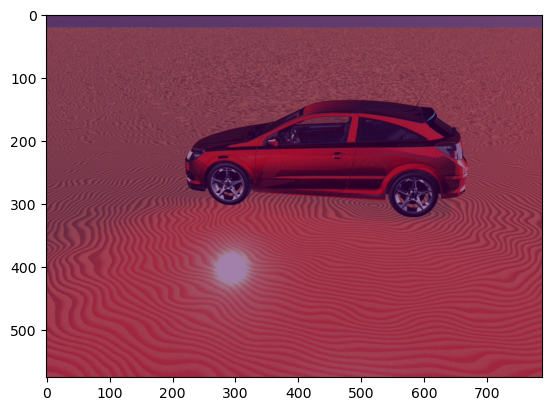

In [30]:
#Here you can try seeing how images are predicted by defining the path, the model is saved as model.pth 
import torchvision.transforms as transforms
from PIL import Image

def predict_image(model, image_path):
    # Load and preprocess the input image
    input_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
      
        transforms.ToTensor()
    ])
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Move the input tensor to the device used during training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_batch = input_batch.to(device)

    # Make the prediction
    with torch.no_grad():
        model.eval()
        output = model(input_batch)

    # Convert the output to probabilities and then binary predictions
    probabilities = torch.sigmoid(output)
    predictions = (probabilities > 0.5).float()

    return predictions.cpu().numpy().squeeze()

# Example usage
loaded_model = UNet()
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=1e-5, weight_decay=1e-4)
loaded_model, loaded_optimizer, _, _, _ = load_model(loaded_model, loaded_optimizer, 'model.pth')
image_path_try= '0010.png'
image_path_to_predict = IMAGES_FOLDER + ORANGE_CAR_FOLDER + NO_SEGMENTATION_FOLDER +image_path_try

predicted_mask = predict_image(loaded_model, image_path_to_predict)
# Visualize the original image and the predicted mask
plt.imshow(Image.open(image_path_to_predict).convert('RGB'))
plt.imshow(predicted_mask, alpha=0.5, cmap='viridis') 
plt.show()


In [ ]:
# model.save('trained_model.h5')

In [ ]:
# Run the output on the test set

In [ ]:
# Try pretrained models: MobileNetV2, ResNet101